In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Задача 1 

Мы рассмотрели несколько вариантов добавления эффекта. Есть ли смысл думать о способе добавления эффекта при оценке вероятности ошибки II рода или все способы дают одинаковый результат? Результаты могут быть разными. Чтобы в этом убедиться, проведём численный эксперимент.

Допустим, в наш А/В-тест попадают все пользователи, совершавшие покупки до 28 марта.

 
Целевая метрика — средняя выручка с клиента за время эксперимента. Целевую метрику считаем на неделе с 21 по 28 марта. Уровень значимости — 0.05. Критерий — тест Стьюдента. Размер групп — 1000. Ожидаемый эффект — средняя выручка увеличится на 10%.

Нужно оценить вероятности ошибок II рода для трёх вариантов добавления эффекта:

1. Добавление константы ко всем значениям;

2. Умножение на константу всех значений;

3. Добавление константы к 2.5% значений.

В качестве ответа введите номера способов добавления эффекта в порядке увеличения оценки вероятности ошибки II рода. Например, если при добавлении константы ко всем значениям оценка вероятности ошибки минимальна, при добавлении константы к 2.5% значений максимальна, то ответ будет: 123.

In [2]:
sales = pd.read_csv("2022-04-01T12_df_sales.csv")

In [3]:
march_sales = sales.query('date <= "2022-03-28" & date >= "2022-03-21"')

In [4]:
users = sales[sales["date"] < "2022-03-28"][["user_id"]].drop_duplicates()
march_metric = (
    sales.query('date <= "2022-03-28" & date >= "2022-03-21"')
    .groupby("user_id")[["price"]]
    .sum()
    .reset_index()
)

df = pd.merge(users, march_metric, on="user_id", how="left").fillna(0)

In [5]:
def plot_pvalue_ecdf(pvalues, alpha=0.05, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat="density")
    ax1.plot([0, 1], [1, 1], "k--")
    ax1.set(xlabel="p-value", ylabel="Density")

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0, 1], [0, 1], "k--")
    ax2.axvline(alpha, color="black")
    ax2.set(xlabel="p-value", ylabel="Probability")
    ax2.grid()

In [6]:
alpha = 0.05
mean = df.price.mean()
std = df.price.std()
sample_size = 1000
mde = 0.1

  0%|          | 0/10000 [00:00<?, ?it/s]

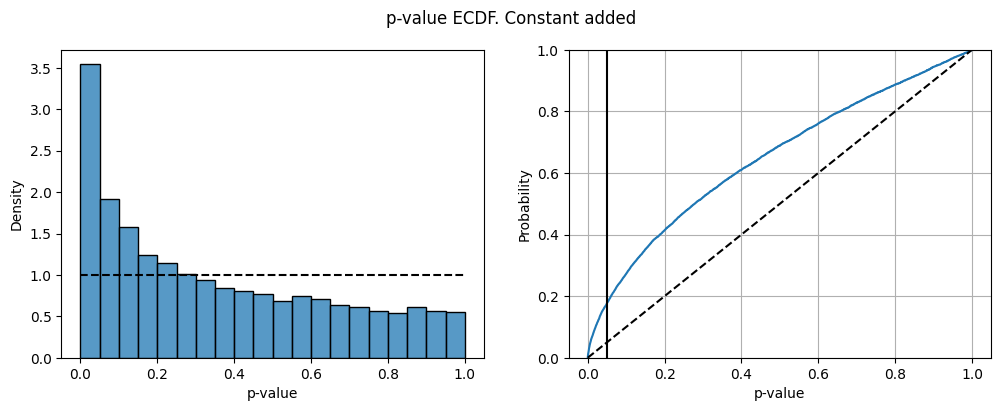

In [7]:
p_values_first_method = []
for _ in tqdm(range(10000)):
    sample_users = df.sample(sample_size * 2)
    a = sample_users.user_id[:sample_size]
    b = sample_users.user_id[sample_size:]
    control = df[df["user_id"].isin(a)].price
    test_constant = df[df["user_id"].isin(b)].price + mean * mde
    p_val = stats.ttest_ind(control, test_constant).pvalue
    p_values_first_method.append(p_val)

plot_pvalue_ecdf(
    p_values_first_method, alpha=alpha, title="p-value ECDF. Constant added"
)
errors_first_method = (np.array(p_values_first_method) > alpha).astype(int)

  0%|          | 0/10000 [00:00<?, ?it/s]

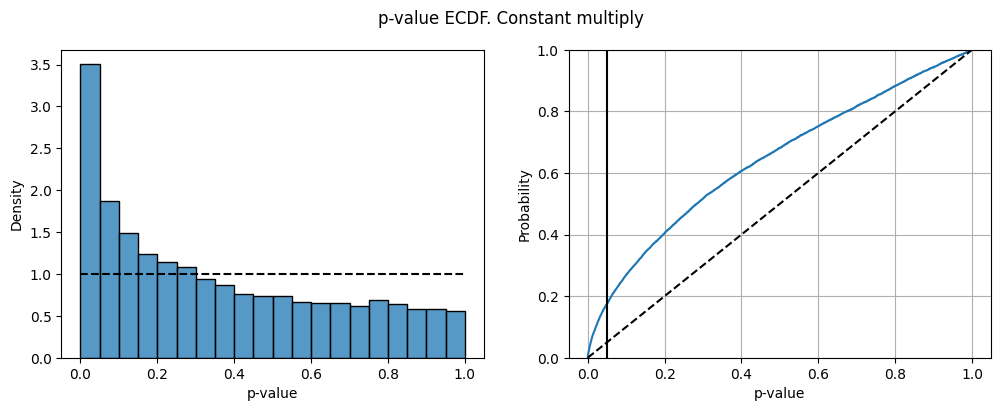

In [8]:
p_values_second_method = []
for _ in tqdm(range(10000)):
    sample_users = df.sample(sample_size * 2)
    a = sample_users.user_id[:sample_size]
    b = sample_users.user_id[sample_size:]
    control = df[df["user_id"].isin(a)].price
    test_constant = df[df["user_id"].isin(b)].price * (1 + mde)
    p_val = stats.ttest_ind(control, test_constant).pvalue
    p_values_second_method.append(p_val)

plot_pvalue_ecdf(
    p_values_second_method,
    alpha=alpha,
    title="p-value ECDF. Constant multiply",
)
errors_second_method = (np.array(p_values_second_method) > alpha).astype(int)

  0%|          | 0/10000 [00:00<?, ?it/s]

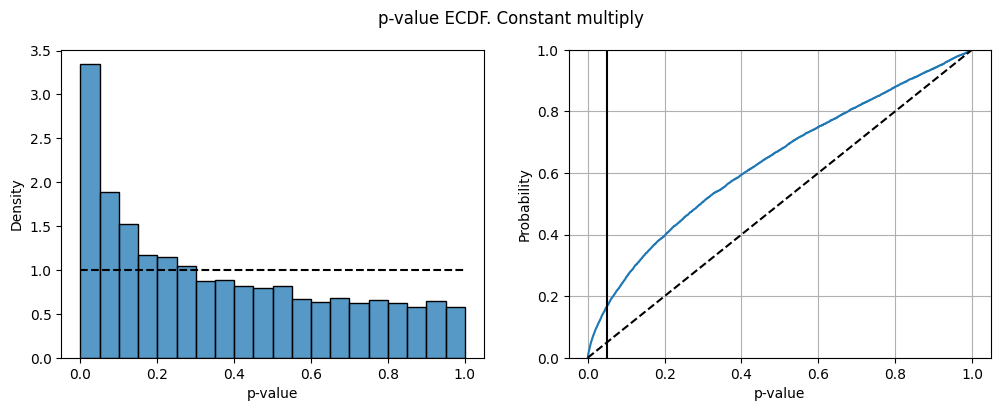

In [9]:
p_values_third_method = []
for _ in tqdm(range(10000)):
    sample_users = df.sample(sample_size * 2)
    a = sample_users.user_id[:sample_size]
    b1 = sample_users.user_id[
        sample_size : int(sample_size + sample_size * 0.025)
    ]
    b2 = sample_users.user_id[int(sample_size + sample_size * 0.025) :]
    control = df[df["user_id"].isin(a)].price
    b1_users = df[df["user_id"].isin(b2)].price
    b2_users = df[
        df["user_id"].isin(b1)
    ].price + mde * mean * sample_size / len(b1)
    test = pd.concat([b1_users, b2_users])

    p_val = stats.ttest_ind(control, test).pvalue
    p_values_third_method.append(p_val)

plot_pvalue_ecdf(
    p_values_third_method, alpha=alpha, title="p-value ECDF. Constant multiply"
)
errors_third_method = (np.array(p_values_third_method) > alpha).astype(int)

In [10]:
print(f"part errors, first method = {np.mean(errors_first_method):0.4f}")
print(f"part errors, second method = {np.mean(errors_second_method):0.4f}")
print(f"part errors, third method = {np.mean(errors_third_method):0.4f}")

part errors, first method = 0.8230
part errors, second method = 0.8249
part errors, third method = 0.8329
